In [93]:
# Import required libraries

import re
import string
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# NLTK
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
stemmer= PorterStemmer()
lemmit=WordNetLemmatizer()

from sklearn.model_selection import train_test_split


# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
# Import dataset

df=pd.read_csv('https://raw.githubusercontent.com/mohittomar2008/Rating-Prediction-over-reviews--NLP/main/review_comments_data.csv', index_col=0)
df.head(2)

,Title,Review,Rating
0,Terrible product,Its only 7 months I bought this product. It wa...,1
1,Absolute rubbish!,Automatically Disconnected so many times.,1


In [95]:
print("Dataset have ",df.shape[0] , 'rows and ', df.shape[1] ,'columns')

Dataset have  32431 rows and  3 columns


In [96]:
# We have 32,081 records and 3 features

In [97]:
df['Rating'].value_counts(normalize=True)

5    0.352348
1    0.253739
4    0.220561
3    0.104190
2    0.069162
Name: Rating, dtype: float64

In [98]:
df.duplicated().sum()

8164

In [99]:
# FIrst of all, we will remove duplicate entries which will not be usful for any prediction other than bias the model

df.drop_duplicates(inplace=True)

In [100]:
print("Dataset after removing duplicate entries is  ",df.shape[0] , 'rows and ', df.shape[1] ,'columns')

Dataset after removing duplicate entries is   24267 rows and  3 columns


In [101]:
df.sample(4)

,Title,Review,Rating
23839,Best in the market!,Best phone,5
23862,Great product,Best budget phone\nAnd good mobile for this pr...,5
28314,Awesome,Good quality and good performance I m very happy,5
8410,Not good,Not good this item. sound clarity no,2


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24267 entries, 0 to 32430
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   24266 non-null  object
 1   Review  24267 non-null  object
 2   Rating  24267 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 758.3+ KB


### Missing Values in Text data

In [103]:
df.isnull().sum()

Title     1
Review    0
Rating    0
dtype: int64

<AxesSubplot:>

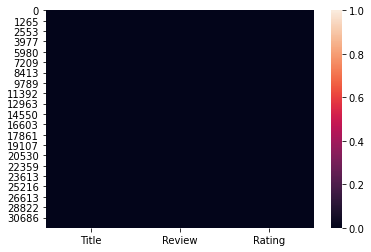

In [104]:
sns.heatmap(df.isnull())

We have only 1 null value in Title feature which is difficult to see in graph. As the missing value quantity is very less, we can drop this

In [105]:
df.dropna(inplace=True)

### Both Title and Review features are in Object datatype which should be in String datatype



In [106]:
df['Title']=df['Title'].astype('string')
df['Review']=df['Review'].astype('string')

In [107]:
df['title_len']= df['Title'].apply(lambda x:len(x))
df['review_len']= df['Review'].apply(lambda x:len(x))

In [108]:
df.sample(3)

,Title,Review,Rating,title_len,review_len
31868,Delightful,Happy to my grandmother,4,10,23
14787,Excellent,Watch is good...and I am satisfied with this w...,5,9,50
3429,Fabulous!,Working great and vibration working great,5,9,41


In [109]:
# Check any random input

df['Title'].loc[100]

'Worthless'

In [110]:
df['Review'].loc[100]

'Bluetooth connectivity is very poor..\nAfter on or off bluetooth not connect to mobile'

In [111]:
df.head(1)

,Title,Review,Rating,title_len,review_len
0,Terrible product,Its only 7 months I bought this product. It wa...,1,16,357


### Text Preprocessing

## Steps to Follow:
    Remove all email addresses
    Remove all website links if any
    Capture emojis
    Remove all special character
    
    Convert into lower case
    Stemmer/Lemmitizer to convert into base word

In [112]:
# we are going to concat Title and Review features

df['comment']=df['Title']+' '+ df['Review']
df.head(2)

,Title,Review,Rating,title_len,review_len,comment
0,Terrible product,Its only 7 months I bought this product. It wa...,1,16,357,Terrible product Its only 7 months I bought th...
1,Absolute rubbish!,Automatically Disconnected so many times.,1,17,41,Absolute rubbish! Automatically Disconnected s...


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24266 entries, 0 to 32430
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       24266 non-null  string
 1   Review      24266 non-null  string
 2   Rating      24266 non-null  int64 
 3   title_len   24266 non-null  int64 
 4   review_len  24266 non-null  int64 
 5   comment     24266 non-null  string
dtypes: int64(3), string(3)
memory usage: 1.8 MB


In [114]:
# Anyhow we are going to analyse words being used to determine whether the comment is good or bad.

In [115]:
stopwords=stopwords.words('english')

In [116]:
type(stopwords)

list

In [117]:
stopwords.remove('not')  # remove 'not from stopwords'

In [118]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

### Handle Emoji's first

In [50]:
# !pip install emot

In [119]:
import re
import pickle

from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS

### Handling Emojis

In [92]:
# 'Emoji_Dict.p'- download link https://drive.google.com/open?id=1G1vIkkbqPBYPKHcQ8qy0G2zkoab2Qv4v

with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
    return text

text = "I won 🥇 in 🏏"
convert_emojis_to_word(text)

'I won 1st_place_medal in cricket'

In [124]:
Emoji_Dict.keys

<function dict.keys>

In [128]:
for i in range(len(df['comment'])):
    df['comment'][i]=convert_emojis_to_word(df['comment'][i])

KeyError: 77

In [24]:
corpus=[]

for i in range(len(x_train)):
    review=re.sub('([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)',' ',x_train['comment'][i]) # remove all email id's
    review=re.sub('[^a-zA-Z]',' ',x_train['comment'][i]) # remove all special comments
    review=review.lower()  # convert text into lower case
    review=review.split()
    
    review=[lemmit.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review=" ".join(review)
    corpus.append(review)

NameError: name 'p' is not defined

NameError: name 'train' is not defined